/tmp/ipykernel_567055/956696525.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


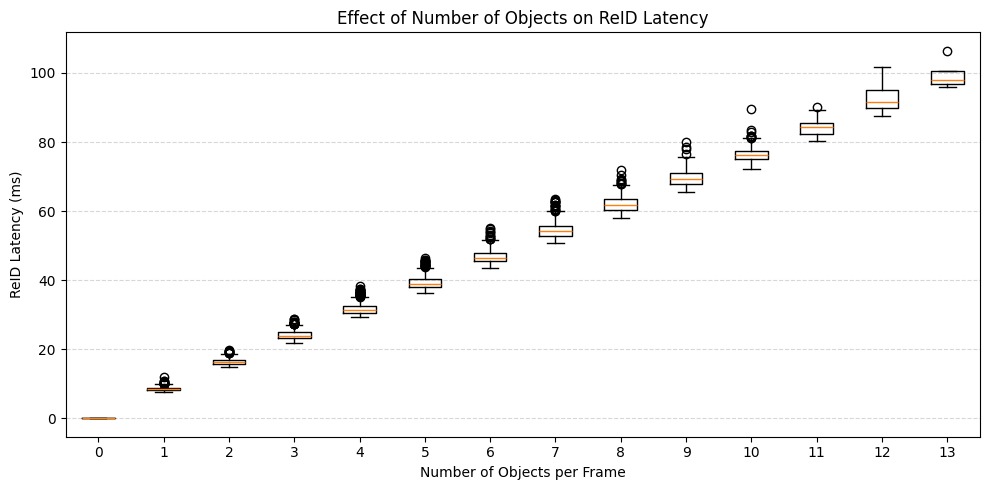

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(
    "output/bellevue_150th_eastgate/batch_size/frame_stats_B1.csv"
)

# keep only relevant columns
df = df[["num_objects", "reid_latency_ms"]]

# drop invalid rows if any
df = df.dropna()

grouped = [
    df[df["num_objects"] == n]["reid_latency_ms"].values / 4.0
    for n in sorted(df["num_objects"].unique())
]

labels = sorted(df["num_objects"].unique())

plt.figure(figsize=(10, 5))

plt.boxplot(
    grouped,
    labels=labels,
    showfliers=True,   # keep outliers (important for batching effects)
)

plt.xlabel("Number of Objects per Frame")
plt.ylabel("ReID Latency (ms)")
plt.title("Effect of Number of Objects on ReID Latency")

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

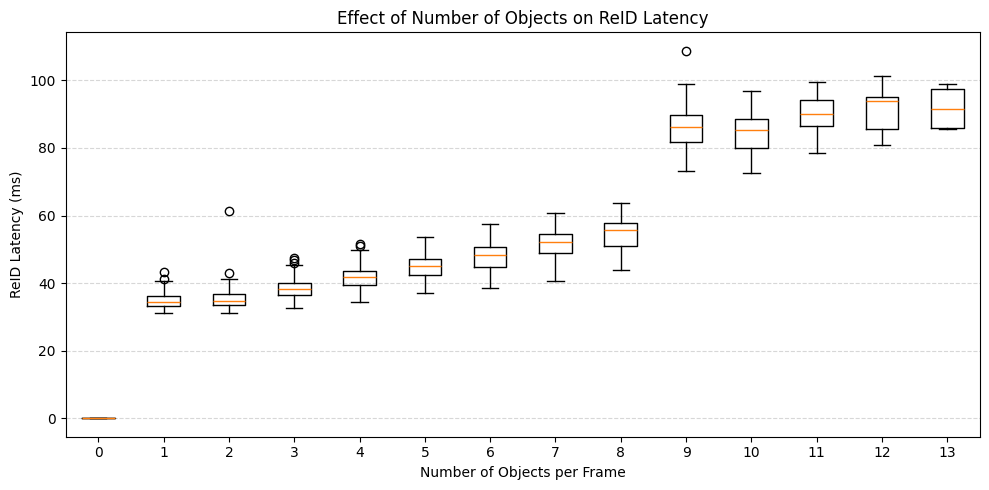

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(
    "output/bellevue_150th_eastgate/CPU_B8_2017-09-11_07-08-31/frame_stats_0.csv"
)

# keep only relevant columns
df = df[["num_objects", "reid_latency_ms"]]

# drop invalid rows if any
df = df.dropna()

grouped = [
    df[df["num_objects"] == n]["reid_latency_ms"].values
    for n in sorted(df["num_objects"].unique())
]

labels = sorted(df["num_objects"].unique())

plt.figure(figsize=(10, 5))

plt.boxplot(
    grouped,
    labels=labels,
    showfliers=True,   # keep outliers (important for batching effects)
)

plt.xlabel("Number of Objects per Frame")
plt.ylabel("ReID Latency (ms)")
plt.title("Effect of Number of Objects on ReID Latency")

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Workload visualization

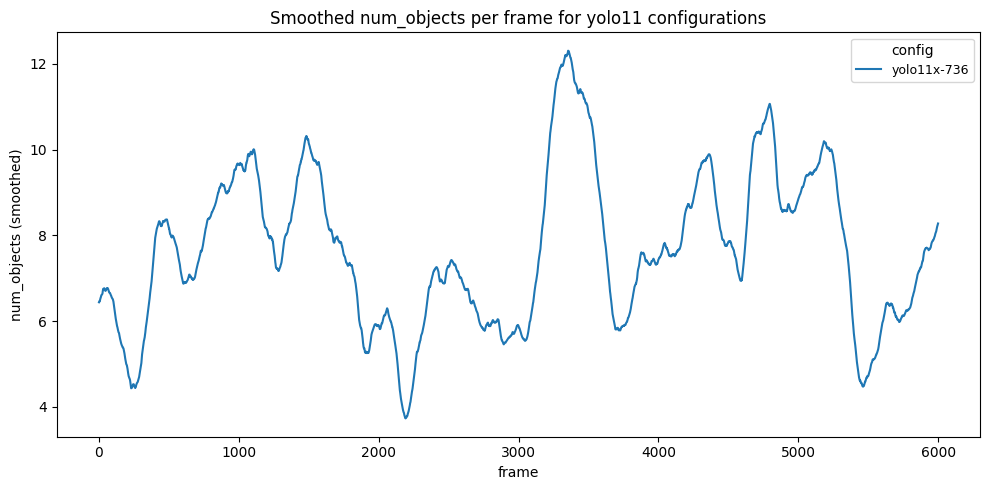

In [ ]:
# Plot smoothed num_objects for every "frame_stats_yolo11*.csv", one line per configuration.
# Smoothing uses a centered moving average. Adjust SMOOTH_WIN as needed.
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# folder containing the CSV files
folder = Path("output/bellevue_150th_eastgate_mask1/2017-09-11_07-08-31")

# smoothing window (in frames)
SMOOTH_WIN = 200  # use an odd number for centered smoothing

# find files
files = sorted(folder.glob("frame_stats_yolo11*.csv"))
if not files:
    raise FileNotFoundError("No CSV files matching 'frame_stats_yolo11*.csv' found.")

def parse_config(path: Path) -> str:
    # expected names like: frame_stats_yolo11l_384.csv or frame_stats_yolo11x_720.csv
    m = re.search(r"frame_stats_(yolo11[a-z])[_\-]?(\d+)?", path.stem, re.IGNORECASE)
    if m:
        model = m.group(1)
        res = m.group(2) if m.group(2) else "NA"
        return f"{model}-{res}"
    return path.stem

plt.figure(figsize=(10, 5))
for f in files:
    cfg = parse_config(f)
    # if "384" not in cfg: continue
    # if "544" not in cfg: continue
    if "736" not in cfg: continue
    df = pd.read_csv(f)
    df = df.rename(columns={c.strip(): c.strip() for c in df.columns})

    if {"frame", "num_objects"} - set(df.columns):
        raise ValueError(f"Missing required columns in {f.name} (need frame and num_objects).")

    df = df.dropna(subset=["frame", "num_objects"]).sort_values("frame")
    df = df[:]
    # centered moving average smoothing
    y_smooth = (
        df["num_objects"]
        .rolling(window=SMOOTH_WIN, min_periods=1, center=True)
        .mean()
    )

    plt.plot(df["frame"], y_smooth, label=cfg)

plt.xlabel("frame")
plt.ylabel("num_objects (smoothed)")
plt.title("Smoothed num_objects per frame for yolo11 configurations")
plt.legend(title="config", ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# Plot smoothed num_objects for every "frame_stats_yolo11*.csv", one line per configuration.
# Smoothing uses a centered moving average. Adjust SMOOTH_WIN as needed.
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# folder containing the CSV files
folder = Path("output/bellevue_150th_eastgate_mask1/2017-09-11_07-08-31")

# smoothing window (in frames)
SMOOTH_WIN = 200  # use an odd number for centered smoothing

# find files
files = sorted(folder.glob("frame_stats_yolo11*.csv"))
if not files:
    raise FileNotFoundError("No CSV files matching 'frame_stats_yolo11*.csv' found.")

def parse_config(path: Path) -> str:
    # expected names like: frame_stats_yolo11l_384.csv or frame_stats_yolo11x_720.csv
    m = re.search(r"frame_stats_(yolo11[a-z])[_\-]?(\d+)?", path.stem, re.IGNORECASE)
    if m:
        model = m.group(1)
        res = m.group(2) if m.group(2) else "NA"
        return f"{model}-{res}"
    return path.stem

plt.figure(figsize=(10, 5))
for f in files:
    cfg = parse_config(f)
    # if "384" not in cfg: continue
    # if "544" not in cfg: continue
    if "736" not in cfg: continue
    df = pd.read_csv(f)
    df = df.rename(columns={c.strip(): c.strip() for c in df.columns})

    if {"frame", "num_objects"} - set(df.columns):
        raise ValueError(f"Missing required columns in {f.name} (need frame and num_objects).")

    df = df.dropna(subset=["frame", "num_objects"]).sort_values("frame")
    df = df[:]
    # centered moving average smoothing
    y_smooth = (
        df["num_objects"]
        .rolling(window=SMOOTH_WIN, min_periods=1, center=True)
        .mean()
    )

    plt.plot(df["frame"], y_smooth, label=cfg)

plt.xlabel("frame")
plt.ylabel("num_objects (smoothed)")
plt.title("Smoothed num_objects per frame for yolo11 configurations")
plt.legend(title="config", ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

### Accuracy

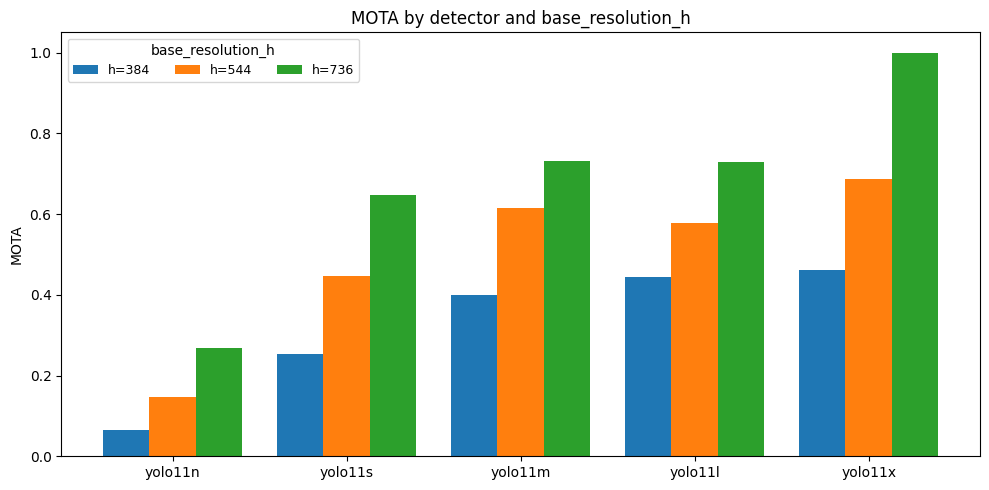

In [15]:
# Grouped bar chart of MOTA by detector, grouped by detector, bars = base_resolution_h
# Ordered from smallest model to largest model (e.g., yolo11n < s < m < l < x)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# path to your CSV
csv_path = Path("output/highway/results.csv")

df = pd.read_csv(csv_path)

# optional: keep only base detector rows (no reid resizing) to avoid duplicates per resolution
# comment this line out if you want to include reid variants
df = df[df["reid_object_w"] == -1]

# normalize columns
df["detector"] = df["detector"].astype(str).str.strip()
df["base_resolution_h"] = pd.to_numeric(df["base_resolution_h"], errors="coerce")
df["MOTA"] = pd.to_numeric(df["MOTA"], errors="coerce")

# detector order from smallest to largest for common YOLO naming
order_map = {"yolo11n": 0, "yolo11s": 1, "yolo11m": 2, "yolo11l": 3, "yolo11x": 4}
detectors = sorted(df["detector"].unique(),
                   key=lambda d: order_map.get(d, 100 + hash(d) % 1000))

# resolutions ascending
resolutions = sorted(df["base_resolution_h"].dropna().unique())

# build value matrix: rows = detectors, cols = resolutions
values = np.full((len(detectors), len(resolutions)), np.nan)
for i, det in enumerate(detectors):
    sub = df[df["detector"] == det]
    for j, res in enumerate(resolutions):
        row = sub[sub["base_resolution_h"] == res]
        if not row.empty:
            # if multiple rows remain, pick the highest MOTA
            values[i, j] = row["MOTA"].max()

# plot grouped bars
x = np.arange(len(detectors))
n_res = len(resolutions)
bar_width = 0.8 / max(n_res, 1)

plt.figure(figsize=(10, 5))
for j, res in enumerate(resolutions):
    heights = values[:, j]
    # replace NaN with 0 for plotting and mask them for labels if desired
    h_plot = np.nan_to_num(heights, nan=0.0)
    positions = x - 0.4 + bar_width/2 + j * bar_width
    plt.bar(positions, h_plot, width=bar_width, label=f"h={int(res)}")

plt.xticks(x, detectors)
plt.ylabel("MOTA")
plt.title("MOTA by detector and base_resolution_h")
plt.ylim(0, 1.05)  # MOTA is in [0,1]
plt.legend(title="base_resolution_h", ncol=min(3, n_res), fontsize=9)
plt.tight_layout()
plt.show()

# Latency

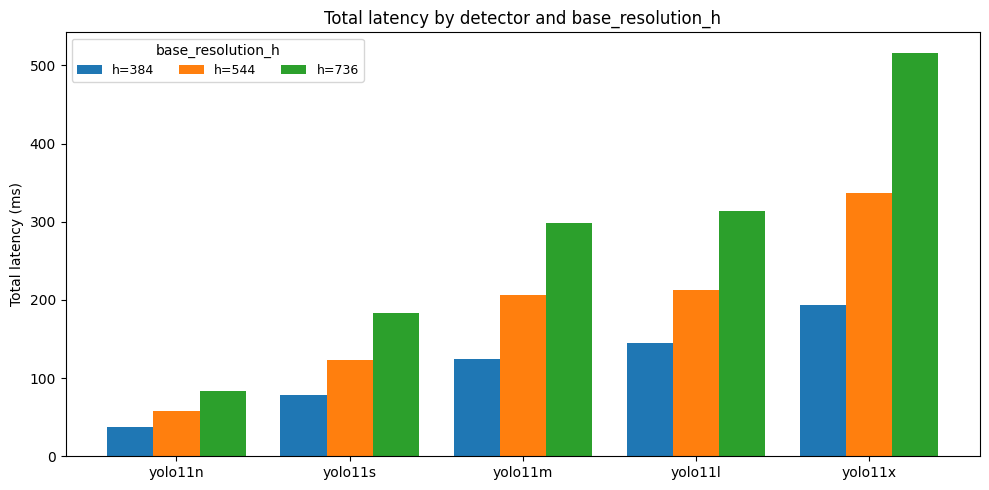

In [ ]:
# Grouped bar chart of TOTAL LATENCY by detector, grouped by detector, bars = base_resolution_h
# Total latency = latency_detection_filter_ms + latency_reid_ms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

csv_path = Path("output/highway/results.csv")
df = pd.read_csv(csv_path)

# keep only base detector rows (no reid resizing)
df = df[df["reid_object_w"] == -1]

# normalize columns
df["detector"] = df["detector"].astype(str).str.strip()
df["base_resolution_h"] = pd.to_numeric(df["base_resolution_h"], errors="coerce")

# compute total latency (ms)
needed = {"latency_detection_filter_ms", "latency_reid_ms"}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Missing latency columns: {missing}")
df["total_latency_ms"] = df["latency_detection_filter_ms"] + df["latency_reid_ms"]

# detector order from smallest to largest for common YOLO naming
order_map = {"yolo11n": 0, "yolo11s": 1, "yolo11m": 2, "yolo11l": 3, "yolo11x": 4}
detectors = sorted(df["detector"].unique(),
                   key=lambda d: order_map.get(d, 100 + hash(d) % 1000))

# resolutions ascending
resolutions = sorted(df["base_resolution_h"].dropna().unique())

# build value matrix: rows = detectors, cols = resolutions
values = np.full((len(detectors), len(resolutions)), np.nan)
for i, det in enumerate(detectors):
    sub = df[df["detector"] == det]
    for j, res in enumerate(resolutions):
        rows = sub[sub["base_resolution_h"] == res]
        if not rows.empty:
            # if multiple rows exist, use mean total latency
            values[i, j] = rows["total_latency_ms"].mean()

# plot grouped bars
x = np.arange(len(detectors))
n_res = len(resolutions)
bar_width = 0.8 / max(n_res, 1)

plt.figure(figsize=(10, 5))
for j, res in enumerate(resolutions):
    heights = values[:, j]
    h_plot = np.nan_to_num(heights, nan=0.0)
    positions = x - 0.4 + bar_width/2 + j * bar_width
    plt.bar(positions, h_plot, width=bar_width, label=f"h={int(res)}")

plt.xticks(x, detectors)
plt.ylabel("Total latency (ms)")
plt.title("Total latency by detector and base_resolution_h")
plt.legend(title="base_resolution_h", ncol=min(3, n_res), fontsize=9)
plt.tight_layout()
plt.show()

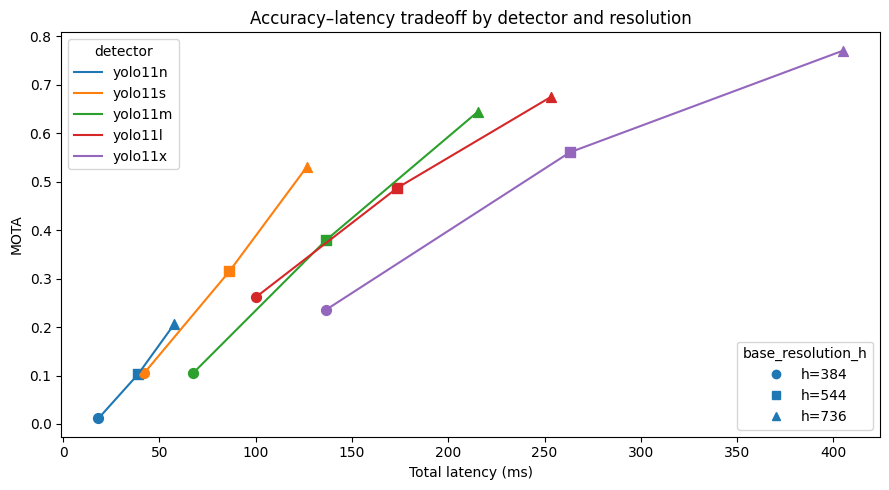

In [2]:
# Scatter (with per-detector lines): x = total latency, y = accuracy (MOTA)
# Groups by detector; point markers indicate base_resolution_h; detectors ordered n < s < m < l < x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

csv_path = Path("output/bellevue_150th_eastgate/results.csv")
df = pd.read_csv(csv_path)

# optional: keep only base detector rows (no reid resizing) to avoid duplicates
# df = df[df["reid_object_w"] == -1]

# normalize and compute totals
df["detector"] = df["detector"].astype(str).str.strip()
df["base_resolution_h"] = pd.to_numeric(df["base_resolution_h"], errors="coerce")
df["MOTA"] = pd.to_numeric(df["MOTA"], errors="coerce")
df["total_latency_ms"] = df["latency_detection_filter_ms"] + df["latency_reid_ms"]

# aggregate per (detector, resolution)
agg = (
    df.groupby(["detector", "base_resolution_h"], as_index=False)
      .agg(total_latency_ms=("total_latency_ms", "mean"),
           MOTA=("MOTA", "mean"))
)

# ordering
order_map = {"yolo11n": 0, "yolo11s": 1, "yolo11m": 2, "yolo11l": 3, "yolo11x": 4}
detectors = sorted(agg["detector"].unique(), key=lambda d: order_map.get(d, 1_000))
resolutions = sorted(agg["base_resolution_h"].dropna().unique())

# marker per resolution
marker_cycle = ["o", "s", "^", "D", "P", "X", "*", "v"]
marker_map = {res: marker_cycle[i % len(marker_cycle)] for i, res in enumerate(resolutions)}

# plot
plt.figure(figsize=(9, 5))
for det in detectors:
    sub = agg[agg["detector"] == det].sort_values("total_latency_ms")
    # line per detector
    line, = plt.plot(sub["total_latency_ms"], sub["MOTA"], label=det)
    # scatter points with marker by resolution, matching the line color
    for _, r in sub.iterrows():
        plt.scatter(r["total_latency_ms"], r["MOTA"],
                    marker=marker_map[r["base_resolution_h"]],
                    s=50,
                    c=[line.get_color()])

# legends: detectors and resolution markers
det_legend = plt.legend(title="detector", loc="best")
plt.gca().add_artist(det_legend)
res_legend_handles = [
    Line2D([0], [0], marker=marker_map[res], linestyle="None", label=f"h={int(res)}")
    for res in resolutions
]
plt.legend(handles=res_legend_handles, title="base_resolution_h", loc="lower right")

plt.xlabel("Total latency (ms)")
plt.ylabel("MOTA")
plt.title("Accuracy–latency tradeoff by detector and resolution")
plt.tight_layout()
plt.show()

### QoE

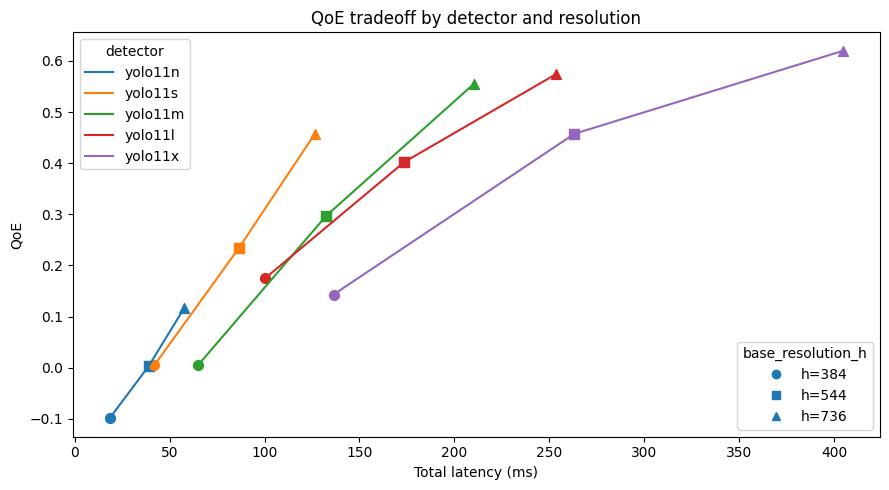

In [28]:
# Scatter (with per-detector lines): x = total latency, y = QoE
# Groups by detector; point markers indicate base_resolution_h
# Detectors ordered n < s < m < l < x

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.lines import Line2D

# -----------------------
# QoE parameters
# -----------------------
D_MIN = 250.0      # ms, adjust to your constraint
MOTA_MIN = 0.1     # minimum acceptable accuracy
GAMMA = 0.0005      # latency sensitivity

def compute_qoe(mean_mota, mean_latency_ms):
    return (mean_mota - MOTA_MIN) * np.exp(-GAMMA * (mean_latency_ms - D_MIN))

# -----------------------
# Load results
# -----------------------
csv_path = Path("output/bellevue_150th_eastgate/results.csv")
df = pd.read_csv(csv_path)

df["detector"] = df["detector"].astype(str).str.strip()
df["base_resolution_h"] = pd.to_numeric(df["base_resolution_h"], errors="coerce")
df["MOTA"] = pd.to_numeric(df["MOTA"], errors="coerce")

df["total_latency_ms"] = (
    df["latency_detection_filter_ms"] + df["latency_reid_ms"]
)

# -----------------------
# Aggregate per config
# -----------------------
agg = (
    df.groupby(["detector", "base_resolution_h"], as_index=False)
      .agg(
          total_latency_ms=("total_latency_ms", "mean"),
          MOTA=("MOTA", "mean"),
      )
)

agg["QoE"] = compute_qoe(agg["MOTA"], agg["total_latency_ms"])

# -----------------------
# Ordering and markers
# -----------------------
order_map = {
    "yolo11n": 0,
    "yolo11s": 1,
    "yolo11m": 2,
    "yolo11l": 3,
    "yolo11x": 4,
}
detectors = sorted(
    agg["detector"].unique(),
    key=lambda d: order_map.get(d, 1_000),
)

resolutions = sorted(agg["base_resolution_h"].dropna().unique())

marker_cycle = ["o", "s", "^", "D", "P", "X", "*", "v"]
marker_map = {
    res: marker_cycle[i % len(marker_cycle)]
    for i, res in enumerate(resolutions)
}

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(9, 5))

for det in detectors:
    sub = agg[agg["detector"] == det].sort_values("total_latency_ms")

    line, = plt.plot(
        sub["total_latency_ms"],
        sub["QoE"],
        label=det,
    )

    for _, r in sub.iterrows():
        plt.scatter(
            r["total_latency_ms"],
            r["QoE"],
            marker=marker_map[r["base_resolution_h"]],
            s=50,
            c=[line.get_color()],
        )

# legends
det_legend = plt.legend(title="detector", loc="best")
plt.gca().add_artist(det_legend)

res_legend_handles = [
    Line2D(
        [0], [0],
        marker=marker_map[res],
        linestyle="None",
        label=f"h={int(res)}",
    )
    for res in resolutions
]
plt.legend(
    handles=res_legend_handles,
    title="base_resolution_h",
    loc="lower right",
)

plt.xlabel("Total latency (ms)")
plt.ylabel("QoE")
plt.title("QoE tradeoff by detector and resolution")
plt.tight_layout()
plt.show()

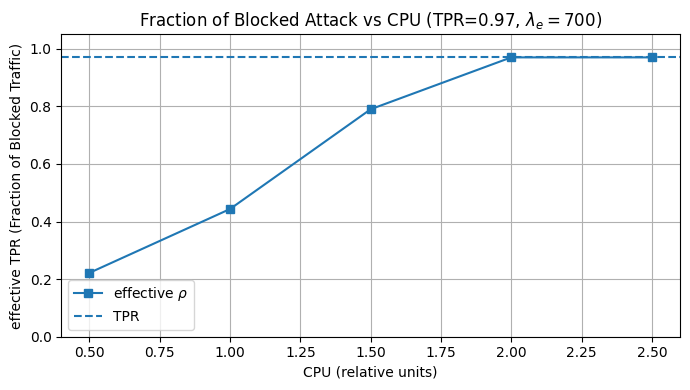

In [2]:
# Plot effective acceptance with a horizontal TPR line
import numpy as np
import matplotlib.pyplot as plt

cpu = np.array([0.5, 1.0, 1.5, 2.0, 2.5], dtype=float)
mu  = np.array([160, 320, 570, 720, 940], dtype=float)
lambda_attack = 700.0
TPR = 0.97

rho = np.minimum(1.0, mu / lambda_attack)
rho_eff = np.minimum(TPR, rho * TPR)

plt.figure(figsize=(7,4))
plt.plot(cpu, rho_eff, marker="s", label="effective $\\rho$")
plt.axhline(TPR, linestyle="--", label="TPR")
plt.xlabel("CPU (relative units)")
plt.ylabel(r"effective TPR (Fraction of Blocked Traffic)")
plt.title(rf"Fraction of Blocked Attack vs CPU (TPR={TPR}, $\lambda_e={int(lambda_attack)}$)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()